In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [ ]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=4)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

## IMPORT DATA, build dataset
### FOR ALL DATA

In [3]:
ds_all = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_all.zarr').persist()
ds_sentinel = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_sentinel.zarr').persist()
ds_saral = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_saral.zarr').persist()
ds_argos = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_argos.zarr').persist()
ds_gps = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_gps.zarr').persist()

In [4]:
ds_all

<xarray.Dataset>
Dimensions:                                                         (id_comb: 72)
Coordinates:
  * id_comb                                                         (id_comb) <U44 ...
Data variables: (12/1412)
    mean_alti_adt_g_grad_x                                          float64 ...
    mean_alti_adt_oceantide_dac_g_grad_x                            float64 ...
    mean_alti_adt_oceantide_g_grad_x                                float64 ...
    mean_alti_denoised_g_grad_x                                     float64 ...
    mean_alti_g_grad_x                                              float64 ...
    mean_aviso_alti_adt_g_grad_x                                    float64 ...
    ...                                                              ...
    var_sum_co_e5_cstrio_z15_alti_x                                 float64 ...
    var_sum_co_e5_cstrio_z15_drifter_x                              float64 ...
    var_sum_co_es_cstrio_z0_alti_x                                  float64 ...
    var_sum_co_es_cstrio_z0_drifter_x                               float64 ...
    var_sum_co_es_cstrio_z15_alti_x                                 float64 ...
    var_sum_co_es_cstrio_z15_drifter_x                              float64 ...

In [5]:
DS = {'all':ds_all, 'sentinel':ds_sentinel,  'saral':ds_saral, 'gps':ds_gps, 'argos':ds_argos}

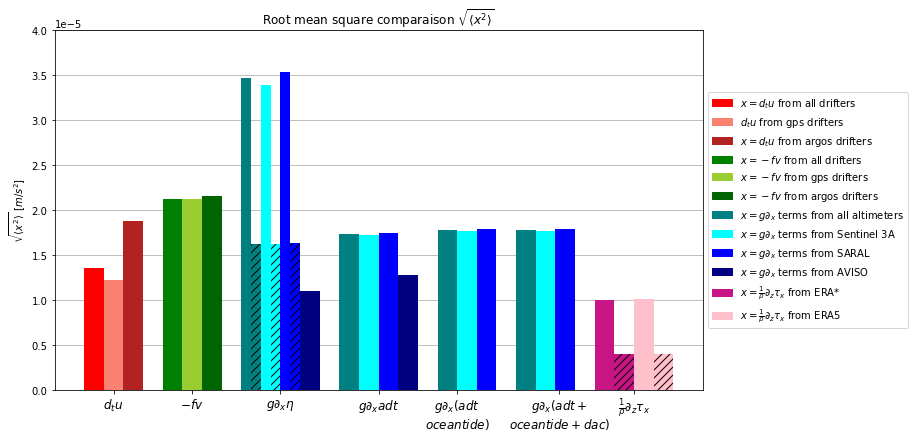

In [6]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_axes([0,0,1,1])
N=[1,2,3,4] 
ax.set_xticks(N, (r'$d_tu$', r'$-fv$', r"$g\partial_x\eta$", r"$g\partial_xadt$", r"$g\partial_x(adt$"+"\n"+r"$oceantide)$", r"$g\partial_x(adt + $"+"\n"+r"$oceantide + dac)$",r'$\frac{1}{\rho}\partial_z\tau_x$'), fontsize=12)

ax.bar(np.arange(0,0.75,0.25),[ds['rms_drifter_acc_x'] for ds in [DS['all'],DS['gps'],DS['argos']]], color = ['red', 'salmon', 'firebrick'],
       width = 0.25, zorder=3)
ax.bar(1 + np.arange(0,0.75,0.25),[ds['rms_drifter_coriolis_x'] for ds in [DS['all'],DS['gps'],DS['argos']]] , color = ['green', 'yellowgreen', 'darkgreen'],
       width = 0.25, zorder=3)

ax.bar(2-0.125/2 + np.arange(0,0.75,0.25),[ds['rms_alti_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.125, zorder=3)
ax.bar(2+0.125/2 + np.arange(0,0.75,0.25),[ds['rms_alti_denoised_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
        hatch=['///']*3, width = 0.125, zorder=3)
ax.bar(2.75 ,ds_all.rms_aviso_alti_g_grad_x, color = ['navy'],
        width = 0.25, zorder=3)

ax.bar(3.25 + np.arange(0,0.75,0.25),[ds['rms_alti_adt_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.25, zorder=3)
ax.bar(4 ,ds_all.rms_aviso_alti_adt_g_grad_x, color = ['navy'],
        width = 0.25, zorder=3)

ax.bar(4.5 + np.arange(0,0.75,0.25),[ds['rms_alti_adt_oceantide_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.25, zorder=3)

ax.bar(5.5 + np.arange(0,0.75,0.25),[ds['rms_alti_adt_oceantide_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.25, zorder=3)

ax.bar(6.5 + np.arange(0,1,0.25), 
       [ds_all.rms_es_cstrio_z0_alti_wd_x,ds_all.rms_es_cstrio_z15_alti_wd_x,
        ds_all.rms_e5_cstrio_z0_alti_wd_x,ds_all.rms_e5_cstrio_z15_alti_wd_x],
       color = ['mediumvioletred']*2+['pink']*2, hatch = ['','///','','///'],
        width = 0.25, zorder=3)

ax.set_ylabel(r'$\sqrt{\langle x^2\rangle}$ [$m/s^2$]')
ax.set_title(r'Root mean square comparaison $\sqrt{\langle x^2\rangle}$')
ax.set_ylim((0,4e-5))
ax.grid(axis='y', zorder=0)

colors=['red', 'salmon', 'firebrick','green', 'yellowgreen', 'darkgreen','teal', 'cyan', 'blue',]+['navy']+['mediumvioletred']+['pink'] 
labels = [r'$x=d_tu$ from all drifters',r'$x=d_tu$ from gps drifters',r'$x=d_tu$ from argos drifters',
          r'$x=-fv$ from all drifters',r'$x=-fv$ from gps drifters',r'$x=-fv$ from argos drifters',
          r"$x=g\partial_x$ terms from all altimeters",r"$x=g\partial_x$ terms from Sentinel 3A",r"$x=g\partial_x$ terms from SARAL",
          r"$x=g\partial_x$ terms from AVISO",
          r'$x=\frac{1}{\rho}\partial_z\tau_x$ from ERA*', r'$x=\frac{1}{\rho}\partial_z\tau_x$ from ERA5',
         ]
hatchs = ['']*9+['///']*3+['','']+['','///','','///']
handles = [plt.Rectangle((0,0),1,1, color=colors[i], hatch=hatchs[i]) for i in range(len(labels))]
fig.legend(handles, labels, ncol=1, fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))#bbox_transform=fig.transFigure,
#fig.legend(handles, labels, bbox_to_anchor=(1,-0.35), loc="lower right", bbox_transform=fig.transFigure, ncol=4, fontsize=10)#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

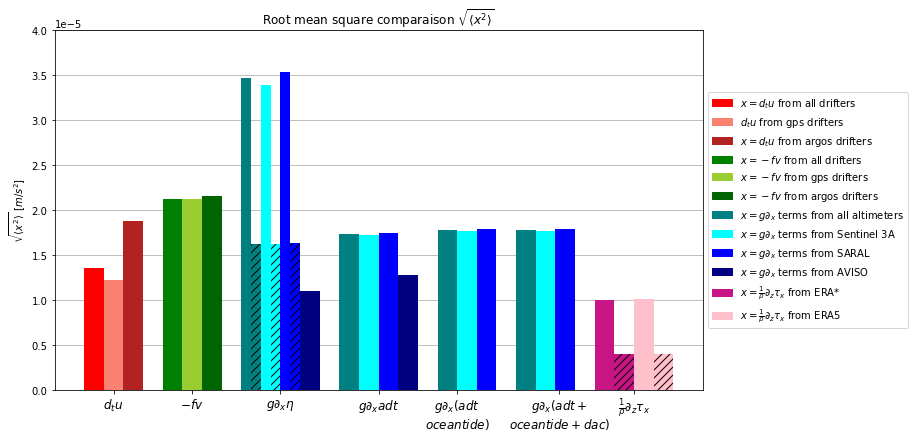

In [6]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_axes([0,0,1,1])
N=[0.25, 1.25,2.375, 2.375+1.25, 5-0.125-0.25, 5.75+0.175,7-0.125,] 
ax.set_xticks(N, (r'$d_tu$', r'$-fv$', r"$g\partial_x\eta$", r"$g\partial_xadt$", r"$g\partial_x(adt$"+"\n"+r"$oceantide)$", r"$g\partial_x(adt + $"+"\n"+r"$oceantide + dac)$",r'$\frac{1}{\rho}\partial_z\tau_x$'), fontsize=12)

ax.bar(np.arange(0,0.75,0.25),[ds['rms_drifter_acc_x'] for ds in [DS['all'],DS['gps'],DS['argos']]], color = ['red', 'salmon', 'firebrick'],
       width = 0.25, zorder=3)
ax.bar(1 + np.arange(0,0.75,0.25),[ds['rms_drifter_coriolis_x'] for ds in [DS['all'],DS['gps'],DS['argos']]] , color = ['green', 'yellowgreen', 'darkgreen'],
       width = 0.25, zorder=3)

ax.bar(2-0.125/2 + np.arange(0,0.75,0.25),[ds['rms_alti_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.125, zorder=3)
ax.bar(2+0.125/2 + np.arange(0,0.75,0.25),[ds['rms_alti_denoised_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
        hatch=['///']*3, width = 0.125, zorder=3)
ax.bar(2.75 ,ds_all.rms_aviso_alti_g_grad_x, color = ['navy'],
        width = 0.25, zorder=3)

ax.bar(3.25 + np.arange(0,0.75,0.25),[ds['rms_alti_adt_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.25, zorder=3)
ax.bar(4 ,ds_all.rms_aviso_alti_adt_g_grad_x, color = ['navy'],
        width = 0.25, zorder=3)

ax.bar(4.5 + np.arange(0,0.75,0.25),[ds['rms_alti_adt_oceantide_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.25, zorder=3)

ax.bar(5.5 + np.arange(0,0.75,0.25),[ds['rms_alti_adt_oceantide_g_grad_x'] for ds in [DS['all'],DS['sentinel'],DS['saral']]], color = ['teal', 'cyan', 'blue'],
       width = 0.25, zorder=3)

ax.bar(6.5 + np.arange(0,1,0.25), 
       [ds_all.rms_es_cstrio_z0_alti_wd_x,ds_all.rms_es_cstrio_z15_alti_wd_x,
        ds_all.rms_e5_cstrio_z0_alti_wd_x,ds_all.rms_e5_cstrio_z15_alti_wd_x],
       color = ['mediumvioletred']*2+['pink']*2, hatch = ['','///','','///'],
        width = 0.25, zorder=3)

ax.set_ylabel(r'$\sqrt{\langle x^2\rangle}$ [$m/s^2$]')
ax.set_title(r'Root mean square comparaison $\sqrt{\langle x^2\rangle}$')
ax.set_ylim((0,4e-5))
ax.grid(axis='y', zorder=0)

colors=['red', 'salmon', 'firebrick','green', 'yellowgreen', 'darkgreen','teal', 'cyan', 'blue',]+['navy']+['mediumvioletred']+['pink'] 
labels = [r'$x=d_tu$ from all drifters',r'$x=d_tu$ from gps drifters',r'$x=d_tu$ from argos drifters',
          r'$x=-fv$ from all drifters',r'$x=-fv$ from gps drifters',r'$x=-fv$ from argos drifters',
          r"$x=g\partial_x$ terms from all altimeters",r"$x=g\partial_x$ terms from Sentinel 3A",r"$x=g\partial_x$ terms from SARAL",
          r"$x=g\partial_x$ terms from AVISO",
          r'$x=\frac{1}{\rho}\partial_z\tau_x$ from ERA*', r'$x=\frac{1}{\rho}\partial_z\tau_x$ from ERA5',
         ]
hatchs = ['']*9+['///']*3+['','']+['','///','','///']
handles = [plt.Rectangle((0,0),1,1, color=colors[i], hatch=hatchs[i]) for i in range(len(labels))]
fig.legend(handles, labels, ncol=1, fontsize=10,loc='center left', bbox_to_anchor=(1, 0.5))#bbox_transform=fig.transFigure,
#fig.legend(handles, labels, bbox_to_anchor=(1,-0.35), loc="lower right", bbox_transform=fig.transFigure, ncol=4, fontsize=10)#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [ ]:
cluster.close()